## MSM of the one dimensional Schütte potential
Here we use another example of one dimensional potential using MasterMSM. In this case, we use the one defined by Schutte and his co-workers (Schutte et al. [*J. Chem. Phys.*, 2011](https://doi.org/10.1063/1.3590108)).

As usual we initialize our notebook by downloading the data from [OSF](https://osf.io/zt2pe/) and importing a number of libraries. 

In [1]:
%load_ext autoreload
%autoreload 2
import h5py
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [3]:
from mastermsm.msm import msm

###  Discretization
We load the trajectory data generated using Brownian dynamics.

In [4]:
h5file = "data/schutte_num5e+08_dt0.0001_fwrite10.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()
x, t = data[:,1], data[:,0]

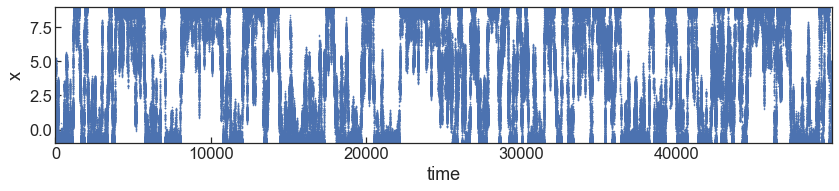

In [5]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(t[:-1:50], x[:-1:50], '.', markersize=1)
ax.set_ylim(-1,9)
ax.set_xlim(0,t[-1])
ax.set_ylabel('x')
ax.set_xlabel('time')
plt.tight_layout()

We can obtain a potential of mean force from a Boltzmann inversion of the probability distribution. We see that the potential consists of two deep basins at the extremes and then four more shallow basins.

<ipython-input-6-9543cf7c4d46>:5: RuntimeWarning: divide by zero encountered in log
  ax.plot(bc, -np.log(h), label='-ln(P(x))', lw=2)


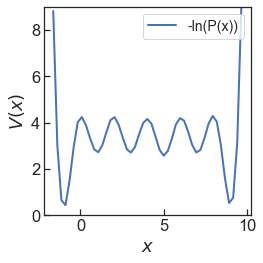

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

h, be = np.histogram(x, bins=np.linspace(-2,10,50), density=True)
bc = [0.5*(be[i] + be[i+1]) for i in range(len(be)-1)]
ax.plot(bc, -np.log(h), label='-ln(P(x))', lw=2)

ax.set_ylabel('$V(x)$')
ax.set_xlabel('$x$')
ax.set_ylim(0,9)
ax.legend(loc=1, fontsize=14)

plt.tight_layout()

We discretize the trajectory by assigning frames to microstates. In this case we use as microstates the indexes of a grid on x.

In [7]:
assigned_trj  = list(np.digitize(x, bins=be))

We then pass the discrete trajectory to the traj module to generate an instance of the TimeSeries class. Using some of its methods, we are able to generate and sort the names of the microstates in the trajectory, which will be useful later.

In [8]:
from mastermsm.trajectory import traj
distraj = traj.TimeSeries(distraj=assigned_trj[:-1:50], dt=1)
distraj.find_keys()
distraj.keys.sort()

## Master Equation Model
After generating the discrete trajectory, we can build the master equation model, for which we use the `msm` module.

In [9]:
from mastermsm.msm import msm

First of all, we will create an instance of the `SuperMSM` class, which will be useful to produce and validate dynamical models. In this case we are using the flag `sym=True` because we are assuming equilibrium sampling.

In [10]:
msm_1D = msm.SuperMSM([distraj], sym=True)

     # states: 47


For the simplest type of dynamical model validation, we carry out a convergence test to check that the relaxation times $\tau$ do not show a dependency on the lag time. We build the MSM at different lag times $\Delta$t.



In [11]:
for lt in [1, 2, 5, 10, 20, 50, 100]:
    msm_1D.do_msm(lt)
    msm_1D.msms[lt].do_trans(evecs=False)
    msm_1D.msms[lt].boots()

 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing


Now the `SuperMSM` object contains a battery of `MSM` objects, each of which corresponds to a given observation window.

In [12]:
msm_1D.msms

{1: <mastermsm.msm.msm.MSM at 0x7fd84060b760>,
 2: <mastermsm.msm.msm.MSM at 0x7fd850d4e820>,
 5: <mastermsm.msm.msm.MSM at 0x7fd860884b50>,
 10: <mastermsm.msm.msm.MSM at 0x7fd860884340>,
 20: <mastermsm.msm.msm.MSM at 0x7fd862cc9f40>,
 50: <mastermsm.msm.msm.MSM at 0x7fd860884ac0>,
 100: <mastermsm.msm.msm.MSM at 0x7fd84060b820>}

We then check the dependence of the relaxation times of the system, $\tau$ with respect to the choice of lag time $\Delta t$. We find that they are very well converged even from the shortest value of $\Delta t$.



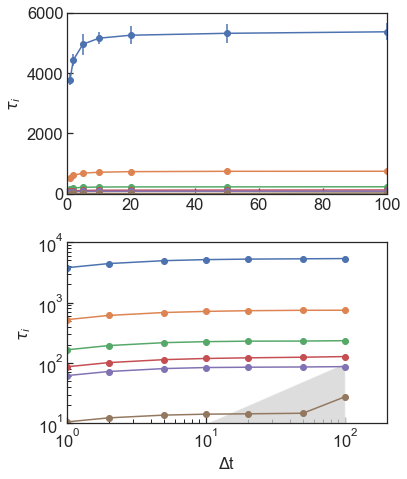

In [13]:
fig,ax=plt.subplots(2,1, figsize=(6,7), sharex=False, sharey=False)
# slowest tau
for i in range(6):
    tau_vs_lagt = np.array([[x, msm_1D.msms[x].tauT[i], msm_1D.msms[x].tau_std[i]] \
                            for x in sorted(msm_1D.msms.keys())])
    ax[0].errorbar(tau_vs_lagt[:,0], tau_vs_lagt[:,1], tau_vs_lagt[:,2], fmt='o-')
    ax[1].errorbar(tau_vs_lagt[:,0], tau_vs_lagt[:,1], tau_vs_lagt[:,2], fmt='o-')
ax[0].fill_between(tau_vs_lagt[:,0], 1e-1, tau_vs_lagt[:,0], facecolor='lightgray', alpha=0.5)
ax[0].fill_between(tau_vs_lagt[:,0], 1e-1, tau_vs_lagt[:,0], facecolor='lightgray', alpha=0.5)
#ax[0].set_ylim(1,100)

ax[1].fill_between(tau_vs_lagt[:,0], 1e-1, tau_vs_lagt[:,0], facecolor='lightgray', alpha=0.5)
ax[1].fill_between(tau_vs_lagt[:,0], 1e-1, tau_vs_lagt[:,0], facecolor='lightgray', alpha=0.5)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(0, 100)
ax[1].set_xlim(1, 200)
ax[0].set_ylim(0,6e3)
ax[1].set_ylim(10,1e4)
ax[1].set_xlabel(r'$\Delta$t', fontsize=16)
ax[0].set_ylabel(r'$\tau_i$', fontsize=16)
ax[1].set_ylabel(r'$\tau_i$', fontsize=16)

plt.tight_layout()

Because the relaxation times are well converged at about 10 frames, we are going to examine more closely the MSM at this lag time.

In [14]:
# lag time selection after convergence test
lt = 10

In [15]:
msm_1D.do_msm(lt)
msm_1D.msms[lt].do_trans(evecs=True)
msm_1D.msms[lt].boots()

 symmetrizing


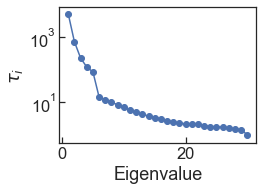

In [16]:
fig, ax = plt.subplots(figsize=(4,3))
ax.errorbar(range(1,len(msm_1D.msms[10].tauT)+1), msm_1D.msms[10].tauT , \
        msm_1D.msms[10].tau_std, fmt='-o')
ax.set_xlabel('Eigenvalue'), ax.set_ylabel(r'$\tau_i$')
ax.set_yscale('log')
plt.tight_layout()

We can notice that in the eigenspectrum there is a gap between the first and second modes, but then another interesting gap between modes 5 and 6. We explore their dynamical content below.

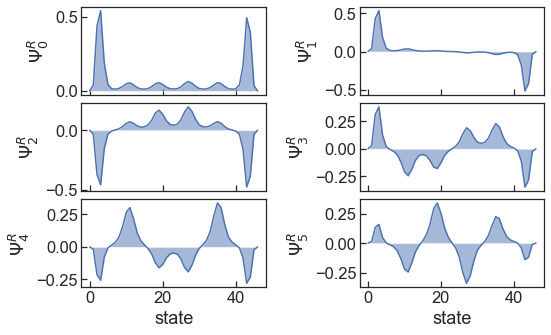

In [17]:
fig, ax = plt.subplots(3,2, sharex=True, figsize=(8,5))

ax = ax.flatten()
for i in range(6):
    ax[i].plot(msm_1D.msms[lt].rvecsT[:,i])
    ax[i].fill_between(range(len(msm_1D.msms[lt].rvecsT[:,i])), \
                   msm_1D.msms[lt].rvecsT[:,i], 0, alpha=0.5)
ax[-2].set_xlabel("state")
ax[-1].set_xlabel("state")

[ax[i].set_ylabel("$\Psi^R_%i$"%i) for i in range(6)]

plt.tight_layout(h_pad=0)

Another interesting thing to look into is the transition matrix itself, where we can see the conditional probabilities of jumping between pairs of states.

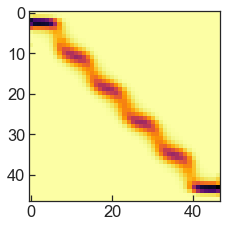

In [18]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.imshow(msm_1D.msms[lt].trans, cmap='inferno_r')
plt.tight_layout()